# Libraries

In [3]:
# !'/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/bin/python' -m pip install accelerate
# !'/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/bin/python' -m pip install diffusers
# !'/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/bin/python' -m pip install datasets
# !'/users/PCS0229/imankhazrak/miniconda3/envs/ddpm_pytorch/bin/python' -m pip install --upgrade pip

In [ ]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import Accelerator
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import timeit

import json


# Hyperparameters

In [2]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4 # 1e-4
NUM_EPOCHS = 512
NUM_GENERATE_IMAGES = 200
NUM_TIMESTEPS = 4000
MIXED_PRECISION = "fp16"
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"


# Pathes

In [4]:
dataname = "NORMAL" #  or dataname = "Pneumonia", "NORMAL"
dir_path = os.getcwd()
save_path = f"{dir_path}/save_model/BATCHSIZE{BATCH_SIZE}_TIMESTEPS{NUM_TIMESTEPS}_EPOCHS{NUM_EPOCHS}_LEARNING_RATE{LEARNING_RATE}_checkpoint_{dataname}.pth"


# Load dataset

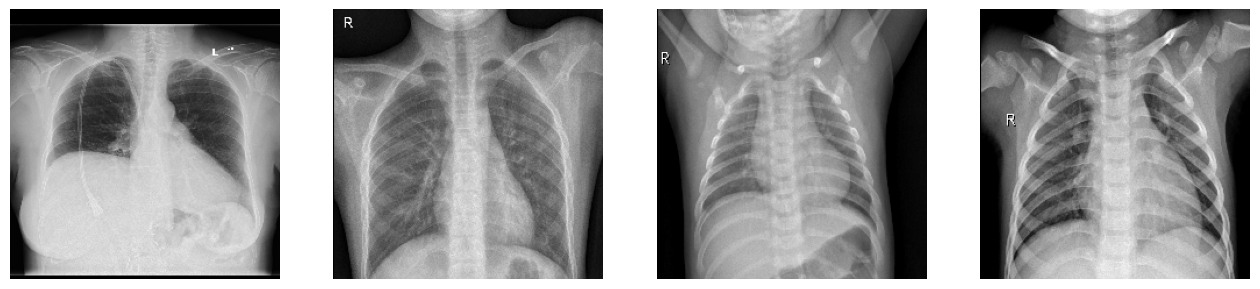

In [6]:
dataset = load_dataset(f"{dir_path}/chest_X_ray_{dataname}", split="train", trust_remote_code=True)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [7]:

preprocess = transforms.Compose(
[
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)


train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)


# U-Net

In [8]:
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(256, 256, 512, 512, 1024, 1024), # (128, 128, 256, 256, 512, 512)
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    )
)
model = model.to(device)

# Model

In [ ]:
sample_image = dataset[0]["images"].unsqueeze(0).to(device)
print("U-NET: Input shape", sample_image.shape)
print("U-NET: Output shape", model(sample_image, timestep=0).sample.shape)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

In [ ]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*NUM_EPOCHS
)

accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)


In [13]:
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler, verbose=0)
    
    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images
    
    fig = plt.figure()
    for i in range(1, num_generate_images+1):
        fig.add_subplot(10, 5, i)
        plt.imshow(images[i-1])
    plt.show()

# Train the model


In [14]:
save_dir = f"{dir_path}/save_images_BATCHSIZE{BATCH_SIZE}_TIMESTEPS{NUM_TIMESTEPS}_EPOCHS{NUM_EPOCHS}_{dataname}_try"
num_generate_images = 50
random_seed = 1
num_timesteps = 1000

In [15]:
def sample_image_generation3(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir, dataname, epoch):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    for i, image in enumerate(images):
        if not os.path.exists(save_dir):
            # If the directory does not exist, create it
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, f"generated_image_{dataname}_{i+1+(epoch*50)}.png")
        if not isinstance(image, Image.Image):
            # Convert tensor image to PIL Image only if necessary
            pil_image = transforms.ToPILImage()(image)
        else:
            # If it's already a PIL image, no need to convert
            pil_image = image
        pil_image.save(save_path)

    fig = plt.figure()
    # for i in range(1, num_generate_images+1):
    for i in range(1, 51):
        fig.add_subplot(10, 5, i)
        plt.imshow(images[i-1])
    plt.show()

In [16]:
def sample_image_generation3(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir, dataname, epoch, verbose=0):
    if verbose == 0:
        with SuppressOutput():
            generate_and_save_images(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir, dataname, epoch)
    else:
        generate_and_save_images(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir, dataname, epoch)

def generate_and_save_images(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir, dataname, epoch):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    for i, image in enumerate(images):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, f"generated_image_{dataname}_{i+1+(epoch*50)}.png")
        if not isinstance(image, Image.Image):
            pil_image = transforms.ToPILImage()(image)
        else:
            pil_image = image
        pil_image.save(save_path)

    fig = plt.figure()
    for i in range(1, 51):
        fig.add_subplot(10, 5, i)
        plt.imshow(images[i-1])
    plt.show()


In [ ]:
start = timeit.default_timer()

training_metrics = {
    'losses': [],
    'mses': [],
    'learning_rates': [],
}

for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    mse_sum = 0  # Initialize sum of MSE for the epoch
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        train_running_loss += loss.item()
        mse_sum += F.mse_loss(noise_pred, noise, reduction='sum').item()
    train_loss = train_running_loss / (idx+1)
    # mse_epoch = mse_sum / (idx + 1) * BATCH_SIZE  # Assuming each batch has BATCH_SIZE samples
    mse_epoch = mse_sum / (len(train_dataloader.dataset))  # Adjust this based on how you calculate MSE

    # Append the metrics for the current epoch to the dictionary
    training_metrics['losses'].append(train_loss)
    training_metrics['mses'].append(mse_epoch)
    training_metrics['learning_rates'].append(lr_scheduler.get_last_lr()[0])
#     print("-"*30)
#     print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
#     print(f"Train MSE EPOCH: {epoch+1}: {mse_epoch:.4f}")

    train_learning_rate = lr_scheduler.get_last_lr()[0]
    print("-"*30)
    print(f"Train Loss EPOCH: {train_running_loss}: {idx+1}")
    print(f"Train Loss EPOCH: {epoch+1}: {train_loss:.4f}")
    print(f"Train Learning Rate EPOCH: {epoch+1}: {train_learning_rate}")
    # If you want to see the results for different epochs, uncomment the lines below
    # if epoch%40 == 0:
        # sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
        # sample_image_generation3(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir, dataname, epoch)
        # print("------iman----")

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")


dir_path = "/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/3. 7200_Machin Learning/Final_project/CS7200_SP2024_Project_G01/Notebooks/DDPM-Pytorch/save_model"

# Check if the directory exists, if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

filename = f"{dir_path}/training_metrics_BATCHSIZE{BATCH_SIZE}_TIMESTEPS{NUM_TIMESTEPS}_EPOCHS{NUM_EPOCHS}_LEARNING_RATE{LEARNING_RATE}_{dataname}.json"

# Save the metrics to the file
with open(filename, 'w') as f:
    json.dump(training_metrics, f)

print(f"Metrics saved to {filename}")

# Saving checkpoints


In [ ]:
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": lr_scheduler.state_dict(),
}


# Save checkpoint
torch.save(checkpoint, save_path)


# Load the checkpoint

In [ ]:
checkpoint = torch.load(save_path)

# Load states into the model, optimizer, and scheduler
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
lr_scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

# If you're resuming training and need to prepare these components with Accelerator again
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)


# Generate Images

In [16]:
def sample_image_generation2(model, noise_scheduler, num_generate_images, random_seed, num_timesteps, save_dir, dataname):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    for i, image in enumerate(images):
        if not os.path.exists(save_dir):
            # If the directory does not exist, create it
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, f"generated_image_{dataname}_{i+1}.png")
        if not isinstance(image, Image.Image):
            # Convert tensor image to PIL Image only if necessary
            pil_image = transforms.ToPILImage()(image)
        else:
            # If it's already a PIL image, no need to convert
            pil_image = image
        pil_image.save(save_path)

    fig = plt.figure()
    # for i in range(1, num_generate_images+1):
    for i in range(1, 10):
        fig.add_subplot(3, 3, i)
        plt.imshow(images[i-1])
    plt.show()

In [ ]:
NUM_GENERATE_IMAGES = 200
RANDOM_SEED = 1
save_dir = f"{dir_path}/save_images_BATCHSIZE{BATCH_SIZE}_TIMESTEPS{NUM_TIMESTEPS}_EPOCHS{NUM_EPOCHS}_{dataname}"
sample_image_generation2(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS, save_dir, dataname)